In [21]:
import data_transformer as transformer
from sklearn.model_selection import train_test_split
from tqdm.auto import trange
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X, y = transformer.make_input_target()

Subject:   0%|          | 0/7 [00:00<?, ?it/s]

keep_interictal:   0%|          | 0/1006 [00:00<?, ?it/s]

keep_preictal:   0%|          | 0/1006 [00:00<?, ?it/s]

keep_interictal:   0%|          | 0/1542 [00:00<?, ?it/s]

keep_preictal:   0%|          | 0/1542 [00:00<?, ?it/s]

keep_interictal:   0%|          | 0/2419 [00:00<?, ?it/s]

keep_preictal:   0%|          | 0/2419 [00:00<?, ?it/s]

keep_interictal:   0%|          | 0/1891 [00:00<?, ?it/s]

keep_preictal:   0%|          | 0/1891 [00:00<?, ?it/s]

keep_interictal:   0%|          | 0/671 [00:00<?, ?it/s]

keep_preictal:   0%|          | 0/671 [00:00<?, ?it/s]

keep_interictal:   0%|          | 0/263 [00:00<?, ?it/s]

keep_preictal:   0%|          | 0/263 [00:00<?, ?it/s]

keep_interictal:   0%|          | 0/210 [00:00<?, ?it/s]

keep_preictal:   0%|          | 0/210 [00:00<?, ?it/s]

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
print('Training:', X_train.shape, y_train.shape)
print('Validation:', X_val.shape, y_val.shape)

Training: (2724,) (2724,)
Validation: (1343,) (1343,)


In [8]:
X_train_mat = []
for i in trange(len(X_train), desc='loadmat'):
    path = X_train[i]
    mat = loadmat(path)
    X_train_mat.append(mat)

loadmat:   0%|          | 0/2724 [00:00<?, ?it/s]

In [11]:
def get_sig(mat):
    segment_name = list(mat.keys())[-1]
    segment = mat[segment_name]
    sig = segment['data'][0][0]
    return sig

In [17]:
def plot_eeg(mat, size_horizontal=8, size_vertical=4):
    segment_name = list(mat.keys())[-1]
    segment = mat[segment_name]
    sig = segment['data'][0][0]
    ch = segment['channels'][0][0][0]
    N = sig.shape[1]
    fs = segment['sampling_frequency'][0][0][0][0]
    t = np.arange(0, N) / fs
    vspace = 1500
    bases = vspace * np.arange(ch.shape[0])
    EEG = sig.T + bases
    plt.figure(figsize=(size_horizontal, size_vertical))
    plt.plot(t, EEG, color='k')
    plt.gca().yaxis.set_ticks(bases)
    plt.gca().yaxis.set_ticklabels(ch)
    plt.xlabel('Time (s)')
    plt.tight_layout()

In [14]:
print(X_train[0])
get_sig(X_train_mat[0]).shape

./data/Dog_5/Dog_5/Dog_5_interictal_segment_0280.mat


(15, 239766)

The raw data here is the signal, which is a $(15 \times 239766)$ matrix representing a 10 min EEG recording for Dog 5. We will call this a data segment matrix. This data segment matrix is a collection of vectors holding micro-voltages recorded from each of the 15 electrodes. A preview is shown below.

In [15]:
get_sig(X_train_mat[0])

array([[ 60,  12,  60, ...,   2, -19,  30],
       [-33,  20, -36, ..., -47,  29, -18],
       [ 14,  14,  -3, ...,  12,  34,  16],
       ...,
       [-16,  58, -12, ..., -35,  28, -29],
       [-13,  -7,  27, ...,  29, -10,  -6],
       [-35,  -5, -15, ...,   1,  24,  28]], dtype=int16)

Further, we can also visualise this segment.

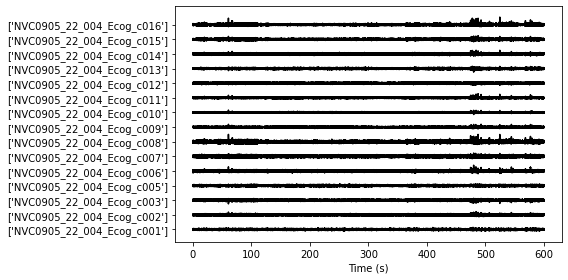

In [22]:
plot_eeg(X_train_mat[0])

Due to the high dimension of the data, the learning algorithm will suffer from the curse of dimensionality. This curse can be broken with feature extraction and dimensionality reduction. 

The benefit of breaking the curse is that the accuracy of the learning algorithm will be increased and training time will decrease.

Since we have ~100GB+ data, a shorter training time is preferable.

Thus, our pre-processing step will aim to perform feature extraction so dimensionality of data can be reduced.

What forms of EEG signal feature extraction methods are available?

Spectral Density Estimation (SDE) is one method of feature extraction. It estimates the power spectral density of a signal from a sequence of time samples. The spectral density characterises the frequency content of the signal.

SDE can be done in two ways: non-parametric and parametric. Non-parametric approach estimates the spectrum of the signal generating process without assuming the process has a particular structure. Parametric spectral estimation assumes the signal is modelled by a stationary process.

SDE can be performed by applying Fast Fourier Transform (FFT), which breaks the incoming signal into a type of power spectrum known as a periodogram. A periodogram is a non-parametric approach to SDE. 

Source: [Wikipedia - Spectral density estimation](https://en.wikipedia.org/wiki/Spectral_density_estimation)

- Spectral density estimation
- Periodogram

What form should this data be converted to, so that we can use traditional machine learning algorithms?

Literature shows there are two approaches:
- Discrete Wavelet Transform (DWT)
- Short-Time Fourier Transform (STFT)

These preserve time information while extracting frequency information and other EEG features.

One goal could be to construct a function that maps a feature vector from the data segment matrix to a correct labelling of the segment.

In this case, each EEG channel could be a feature.
